In [1]:
import pandas as pd
import numpy as np
# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
# for Box-Cox Transformation
from scipy import stats
# for min_max scaling
from mlxtend.preprocessing import minmax_scaling



## Data Loading

In [5]:
train_df = pd.read_csv("/Users/meghas/EPITA/S2/gitandVersioning/dsp-megha-sudheendran/data/train.csv")
test_X = pd.read_csv("/Users/meghas/EPITA/S2/gitandVersioning/dsp-megha-sudheendran/data/test.csv")
test_y = pd.read_csv("/Users/meghas/EPITA/S2/gitandVersioning/dsp-megha-sudheendran/data/sample_submission.csv")

print(train_df.shape)
print(test_X.shape)
print(test_y.shape)

(1460, 81)
(1459, 80)
(1459, 2)


In [6]:
print(train_df.head(5))

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

## Analysing the dataset 

In [7]:
# how many total missing values do we have?
def missingValues(df):
    missing_values_count = df.isnull().sum()

    total_cells = np.product(df.shape)
    total_missing = missing_values_count.sum()

    # percent of data that is missing
    percent_missing = (total_missing/total_cells) * 100
    print('percent_missing : ',percent_missing,"%")
    print('missing_values_count : ',missing_values_count)

In [8]:
missingValues(train_df)

percent_missing :  5.889565364451209 %
missing_values_count :  Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


## Data preprocessing

### Based on the missing value count, we can eliminate few colums
- Id -> no effect on target
- Alley -> 93% missing values
- LotFrontage -> 17% missing values
- FireplaceQu -> 47 % missing values
- GarageType-> missing values



### Based on the covariance, we can eliminate few colums

- YrSold -> 0 covariance
- Utilities-> 0.005 covariance
- Street -> 0.02
- Condition2 ->0.07
- RoofMatl -> 0.116

In [9]:

train_df = train_df.drop(['GarageType','Street','Condition2','MasVnrType','RoofMatl','Id', 'Alley','LotFrontage','FireplaceQu','YrSold','Utilities'], axis=1)


In [10]:
train_df.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,180921.195890
std,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,79442.502883
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,34900.000000
25%,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,129975.000000
50%,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,163000.000000
75%,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,214000.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,755000.000000


In [11]:
missingValues(train_df)

percent_missing :  4.459882583170254 %
missing_values_count :  MSSubClass       0
MSZoning         0
LotArea          0
LotShape         0
LandContour      0
                ..
MiscVal          0
MoSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 70, dtype: int64


In [12]:
train_df.isnull().sum()[10:30]

HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
Exterior1st      0
Exterior2nd      0
MasVnrArea       8
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinSF1       0
BsmtFinType2    38
BsmtFinSF2       0
BsmtUnfSF        0
dtype: int64

### Find the most occuring value to fill in null 

In [13]:

print(train_df['Electrical'].value_counts().idxmax())
print(train_df['BsmtQual'].value_counts().idxmax())
print(train_df['BsmtCond'].value_counts().idxmax())
print(train_df['BsmtExposure'].value_counts().idxmax())
print(train_df['BsmtFinType1'].value_counts().idxmax())
print(train_df['BsmtFinType2'].value_counts().idxmax())
print(train_df['MasVnrArea'].value_counts().idxmax())

train_df['Electrical'].fillna(train_df['Electrical'].value_counts().idxmax(), inplace=True)
train_df['BsmtQual'].fillna(train_df['BsmtQual'].value_counts().idxmax(), inplace=True)
train_df['BsmtCond'].fillna(train_df['BsmtCond'].value_counts().idxmax(), inplace=True)
train_df['BsmtExposure'].fillna(train_df['BsmtExposure'].value_counts().idxmax(), inplace=True)
train_df['BsmtFinType1'].fillna(train_df['BsmtFinType1'].value_counts().idxmax(), inplace=True)
train_df['BsmtFinType2'].fillna(train_df['BsmtFinType2'].value_counts().idxmax(), inplace=True)
train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].value_counts().idxmax(), inplace=True)



SBrkr
TA
TA
No
Unf
Unf
0.0


### Converting the categorical values to numerical

In [14]:
print('Numerical colims: ',list(train_df._get_numeric_data().columns))
categorical_colums = list(set(train_df.columns)-set(train_df._get_numeric_data().columns))
print('\nCategorical_colums: ',categorical_colums)


Numerical colims:  ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'SalePrice']

Categorical_colums:  ['BsmtCond', 'HouseStyle', 'ExterCond', 'SaleType', 'LandSlope', 'ExterQual', 'Functional', 'SaleCondition', 'Electrical', 'Exterior2nd', 'LotConfig', 'LotShape', 'BsmtExposure', 'PoolQC', 'BldgType', 'GarageFinish', 'BsmtQual', 'MiscFeature', 'Fence', 'LandContour', 'Condition1', 'Heating', 'Exterior1st', 'Foundation', 'MSZoning', 'RoofStyle', 'GarageQual', 'HeatingQC', 'CentralAir', 'BsmtFinType2', 'GarageCond', 'Neighborhood', 'KitchenQual', 'BsmtFinType1', 'Pave

In [15]:
# converting categorical values to numerical

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
train_df[categorical_colums] = enc.fit_transform(train_df[categorical_colums])


In [16]:
print('Numerical colims: ',list(train_df._get_numeric_data().columns))
categorical_colums = list(set(train_df.columns)-set(train_df._get_numeric_data().columns))
print('\nCategorical_colums: ',categorical_colums)



Numerical colims:  ['MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'SaleType', 'SaleCondition', 'SalePrice']

Categorical_c

## Finding the correlation of different colum to 'SalePrice'

In [17]:
cor = train_df[train_df.columns[:train_df.shape[1]]].corr(method='pearson')['SalePrice']
cor[cor<0.25]
# print(list(cor))

MSSubClass      -0.084284
MSZoning        -0.166872
LotShape        -0.255580
LandContour      0.015453
LotConfig       -0.067396
LandSlope        0.051152
Neighborhood     0.210851
Condition1       0.091155
BldgType        -0.085591
HouseStyle       0.180163
OverallCond     -0.077856
RoofStyle        0.222405
Exterior1st      0.103551
Exterior2nd      0.103766
ExterQual       -0.636884
ExterCond        0.117303
BsmtQual        -0.618025
BsmtCond         0.052563
BsmtExposure    -0.295407
BsmtFinType1    -0.092106
BsmtFinType2     0.033235
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
Heating         -0.098812
HeatingQC       -0.400178
Electrical       0.234945
LowQualFinSF    -0.025606
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
KitchenQual     -0.589189
Functional       0.115328
GarageFinish    -0.513105
GarageQual       0.115119
GarageCond       0.150576
PavedDrive       0.231357
EnclosedPorch   -0.128578
3SsnPorch   

### For now, lets drop colums with less than 0.25 correlation

In [18]:
most_related_colums = ['MSSubClass','MSZoning','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1'      
,'BldgType','HouseStyle','OverallCond','RoofStyle','Exterior1st','Exterior2nd','ExterQual' 
,'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF2'  
,'BsmtUnfSF','Heating','HeatingQC','Electrical','LowQualFinSF','BsmtFullBath','BsmtHalfBath','BedroomAbvGr'   
,'KitchenAbvGr','KitchenQual','Functional','GarageFinish','GarageQual','GarageCond','PavedDrive'    
,'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','Fence','MiscFeature','MiscVal'     
,'MoSold','SaleType','SaleCondition','GarageYrBlt']
train_df = train_df.drop(most_related_colums, axis=1)

missingValues(train_df)

percent_missing :  0.0 %
missing_values_count :  LotArea         0
OverallQual     0
YearBuilt       0
YearRemodAdd    0
MasVnrArea      0
Foundation      0
BsmtFinSF1      0
TotalBsmtSF     0
CentralAir      0
1stFlrSF        0
2ndFlrSF        0
GrLivArea       0
FullBath        0
HalfBath        0
TotRmsAbvGrd    0
Fireplaces      0
GarageCars      0
GarageArea      0
WoodDeckSF      0
OpenPorchSF     0
SalePrice       0
dtype: int64


### See the features that are highly related

In [19]:
cor[cor>0.5]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

## Visualising most related features 

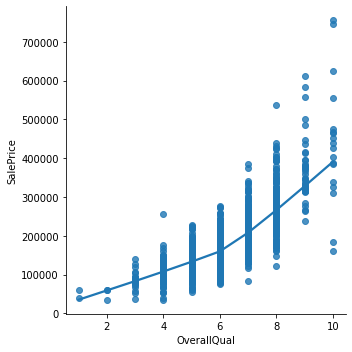

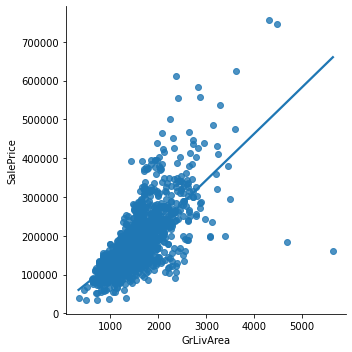

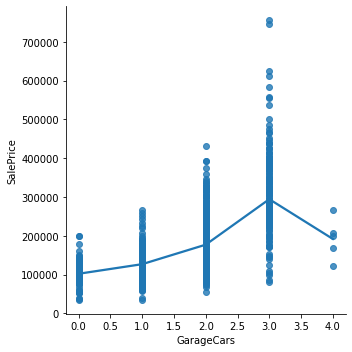

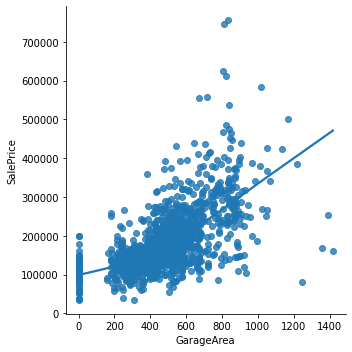

In [20]:
sns.lmplot(x="OverallQual", y="SalePrice", data=train_df, lowess=True);
sns.lmplot(x="GrLivArea", y="SalePrice", data=train_df, lowess=True);
sns.lmplot(x="GarageCars", y="SalePrice", data=train_df, lowess=True);
sns.lmplot(x="GarageArea", y="SalePrice", data=train_df, lowess=True);

### Feature Scaling
#### Our dataset contains numerical values with different scale. Innorder to make the model predict correctly, we need to scale all features to same range

In [21]:
train_df.describe()

,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,Foundation,BsmtFinSF1,TotalBsmtSF,CentralAir,1stFlrSF,...,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,6.099315,1971.267808,1984.865753,103.117123,1.396575,443.639726,1057.429452,0.934932,1162.626712,...,1515.463699,1.565068,0.382877,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,180921.195890
std,9981.264932,1.382997,30.202904,20.645407,180.731373,0.722394,456.098091,438.705324,0.246731,386.587738,...,525.480383,0.550916,0.502885,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,79442.502883
min,1300.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,334.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,7553.500000,5.000000,1954.000000,1967.000000,0.000000,1.000000,0.000000,795.750000,1.000000,882.000000,...,1129.500000,1.000000,0.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,129975.000000
50%,9478.500000,6.000000,1973.000000,1994.000000,0.000000,1.000000,383.500000,991.500000,1.000000,1087.000000,...,1464.000000,2.000000,0.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,163000.000000
75%,11601.500000,7.000000,2000.000000,2004.000000,164.250000,2.000000,712.250000,1298.250000,1.000000,1391.250000,...,1776.750000,2.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,214000.000000
max,215245.000000,10.000000,2010.000000,2010.000000,1600.000000,5.000000,5644.000000,6110.000000,1.000000,4692.000000,...,5642.000000,3.000000,2.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,755000.000000


In [22]:
train_y = train_df['SalePrice']
train_X = train_df.drop(['SalePrice'], axis = 1)


In [23]:
print(train_y.shape)
print(train_X.shape)

(1460,)
(1460, 20)


In [24]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler(copy=True)
columns = train_X.columns
train_X[columns] = scalar.fit_transform(train_X[columns])
train_X.describe()


,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,Foundation,BsmtFinSF1,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.043080,0.566591,0.719332,0.581096,0.064448,0.279315,0.078604,0.173065,0.934932,0.190139,0.168035,0.222582,0.521689,0.191438,0.376484,0.204338,0.441781,0.333554,0.109970,0.085302
std,0.046653,0.153666,0.218862,0.344090,0.112957,0.144479,0.080811,0.071801,0.246731,0.088708,0.211394,0.098998,0.183639,0.251443,0.135449,0.214889,0.186829,0.150779,0.146253,0.121126
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029229,0.444444,0.594203,0.283333,0.000000,0.200000,0.000000,0.130237,1.000000,0.125746,0.000000,0.149868,0.333333,0.000000,0.250000,0.000000,0.250000,0.235896,0.000000,0.000000
50%,0.038227,0.555556,0.731884,0.733333,0.000000,0.200000,0.067948,0.162275,1.000000,0.172786,0.000000,0.212886,0.666667,0.000000,0.333333,0.333333,0.500000,0.338505,0.000000,0.045704
75%,0.048150,0.666667,0.927536,0.900000,0.102656,0.400000,0.126196,0.212480,1.000000,0.242600,0.352542,0.271807,0.666667,0.500000,0.416667,0.333333,0.500000,0.406206,0.196033,0.124314
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
print(train_y)

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64


In [26]:
train_y= train_y/1000000

In [27]:
train_y

0       0.208500
1       0.181500
2       0.223500
3       0.140000
4       0.250000
          ...   
1455    0.175000
1456    0.210000
1457    0.266500
1458    0.142125
1459    0.147500
Name: SalePrice, Length: 1460, dtype: float64

### Analysing and preprocessing of test dataset

In [28]:
missingValues(test_X)

percent_missing :  5.9972583961617545 %
missing_values_count :  Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


In [29]:
def preprocess_testData(test_X):
    test_X = test_X.drop(['GarageType','Street','Condition2','MasVnrType','RoofMatl','Id', 'Alley','LotFrontage','FireplaceQu','YrSold','Utilities'], axis=1)

    test_X['Electrical'].fillna(test_X['Electrical'].value_counts().idxmax(), inplace=True)
    test_X['BsmtQual'].fillna(test_X['BsmtQual'].value_counts().idxmax(), inplace=True)
    test_X['BsmtCond'].fillna(test_X['BsmtCond'].value_counts().idxmax(), inplace=True)
    test_X['BsmtExposure'].fillna(test_X['BsmtExposure'].value_counts().idxmax(), inplace=True)
    test_X['BsmtFinType1'].fillna(test_X['BsmtFinType1'].value_counts().idxmax(), inplace=True)
    test_X['BsmtFinType2'].fillna(test_X['BsmtFinType2'].value_counts().idxmax(), inplace=True)
    test_X['MasVnrArea'].fillna(test_X['MasVnrArea'].value_counts().idxmax(), inplace=True)
    test_X['BsmtFinSF1'].fillna(test_X['BsmtFinSF1'].value_counts().idxmax(), inplace=True)
    test_X['TotalBsmtSF'].fillna(test_X['TotalBsmtSF'].value_counts().idxmax(), inplace=True)
    test_X['GarageCars'].fillna(test_X['GarageCars'].value_counts().idxmax(), inplace=True)
    test_X['GarageArea'].fillna(test_X['GarageArea'].value_counts().idxmax(), inplace=True)





    categorical_colums = list(set(test_X.columns)-set(test_X._get_numeric_data().columns))
    enc = OrdinalEncoder()
    test_X[categorical_colums] = enc.fit_transform(test_X[categorical_colums])
    
    most_related_colums = ['MSSubClass','MSZoning','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1'      
    ,'BldgType','HouseStyle','OverallCond','RoofStyle','Exterior1st','Exterior2nd','ExterQual' 
    ,'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF2'  
    ,'BsmtUnfSF','Heating','HeatingQC','Electrical','LowQualFinSF','BsmtFullBath','BsmtHalfBath','BedroomAbvGr'   
    ,'KitchenAbvGr','KitchenQual','Functional','GarageFinish','GarageQual','GarageCond','PavedDrive'    
    ,'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','Fence','MiscFeature','MiscVal'     
    ,'MoSold','SaleType','SaleCondition','GarageYrBlt']
    test_X = test_X.drop(most_related_colums, axis=1)
    
    scalar = MinMaxScaler(copy=True)
    columns = test_X.columns
    test_X[columns] = scalar.fit_transform(test_X[columns])


    return test_X


test_X = preprocess_testData(test_X)



## Model training and evaluation

### Model 1: RandomForestRegressor

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

RandomForestRegressor_model = RandomForestRegressor(max_depth=2, random_state=0)


RandomForestRegressor_model.fit(train_X, train_y)
model_1_prediction = RandomForestRegressor_model.predict(test_X)*1000000
model_1_prediction

array([133699.69760242, 140267.84331452, 148541.58456411, ...,
       135650.18632291, 133699.69760242, 202666.17442414])

### Model 2: GradientBoostingRegressor

In [33]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

GradientBoostingRegressor_model = GradientBoostingRegressor(learning_rate=0.001, n_estimators=100,random_state=0)
GradientBoostingRegressor_model.fit(train_X, train_y)

model_2_prediction = GradientBoostingRegressor_model.predict(test_X)*1000000
model_2_prediction

array([175588.27867535, 175588.27867535, 179449.74835491, ...,
       175588.27867535, 175588.27867535, 187418.69587177])

## Model Evaluation

In [34]:
from sklearn.metrics import mean_squared_log_error

def compute_rmsle(y_test: np.ndarray, y_pred: np.ndarray, precision: int = 2) -> float:
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    return round(rmsle, precision)



In [35]:
rmsle_model1 = compute_rmsle(test_y['SalePrice'],model_1_prediction)
rmsle_model2 = compute_rmsle(test_y['SalePrice'],model_2_prediction)

print("mean_squared_log_error of Model 1: ", rmsle_model1)
print("mean_squared_log_error of Model 2: ", rmsle_model2)

mean_squared_log_error of Model 1:  0.29
mean_squared_log_error of Model 2:  0.09


In [36]:

output = pd.DataFrame({'Id': test_y['Id'],'SalePrice': rmsle_model2})
output.to_csv('submission.csv', index=False)